<a href="https://colab.research.google.com/github/DanielFadlon/AIforHealthcare-ObjectDetection/blob/main/experiment_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Colab

after uploading the fined tuned moel to our google drive

In [1]:
SOURCE_LIVER_PATH = './Task03_Liver'

PROJ_DIR_PATH_BRODSKY = "/content/drive/My Drive/IDC/MSc/Healthcare AI" # /content/gdrive/Shared drives/AIforHealthcare/objectDetection
PROJ_DIR_PATH_FADLON = '/content/drive/MyDrive/AIforHealthcare/objectDetection'

#  ------------- Select your project directory ------------- #
PROJ_DIR_PATH = PROJ_DIR_PATH_FADLON

In [2]:
!pip install gdown
!pip install nibabel
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.6 MB/s eta 0:00:00


In [3]:
#Files
import tarfile
import shutil
import json

# ML / AI / Vision
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
from torchvision.ops import masks_to_boxes
from scipy.ndimage import label as scipy_label
from torchvision.models.detection import retinanet_resnet50_fpn_v2

# Evaluation
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Visual
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib

# General
import os
from typing import Optional, Tuple, List, Dict
from tqdm import tqdm
from dataclasses import dataclass, asdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pprint import pprint
import time
import datetime
import traceback


from google.colab import drive

torchvision.__version__, torch.__version__

('0.15.2+cu118', '2.0.1+cu118')

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if os.path.exists(PROJ_DIR_PATH):
  GDRIVE_SLICES_JSON_PATH = os.path.join(PROJ_DIR_PATH, "slices_data.json")
  GDRIVE_LIVER_DATA_PATH= os.path.join(PROJ_DIR_PATH, "Task03_Liver")

  os.listdir(GDRIVE_LIVER_DATA_PATH), os.path.exists(GDRIVE_SLICES_JSON_PATH)

## Load Data

In [8]:
### ---- load from Drive ---- ###

with open(GDRIVE_SLICES_JSON_PATH, "r") as f:
    data = json.load(f)

df_data = pd.DataFrame(data)

In [6]:
bbox = Tuple[float, float, float, float]

In [7]:
@dataclass
class LiverSlice():
  liver_image: str
  label_image: str
  slice_number: int
  has_liver: bool
  has_cancer: bool
  cancer_bbox: List[bbox]

### Remove invalid bounding boxes

In [11]:
def is_bbox_valid(bbox):
  """Returns True if the bounding box is valid, False otherwise"""
  if bbox is None:
    return False

  x1, y1, x2, y2 = bbox
  return x1 < x2 and y1 < y2

def remove_invalid_bbox_if_needed(boxes):
    """Returns the list of valid bounding boxes, or None if all bounding boxes are invalid"""
    valid_boxes = [box for box in boxes if is_bbox_valid(box)]
    return valid_boxes if len(valid_boxes) > 0 else None


In [12]:
df_data['valid_cancer_bbox'] = df_data['cancer_bbox'].apply(remove_invalid_bbox_if_needed)

In [13]:
with_cancer = df_data[df_data['has_cancer'] == True]

print("Total invalid slices:", with_cancer['valid_cancer_bbox'].isna().sum())
print("Total valid slices:", with_cancer['valid_cancer_bbox'].notna().sum())

print("Total removed bounding boxes:", with_cancer['cancer_bbox'].apply(lambda x: len(x or [])).sum() - with_cancer['valid_cancer_bbox'].apply(lambda x: len(x or [])).sum())

Total invalid slices: 53
Total valid slices: 7137
Total removed bounding boxes: 1305


Finally, remove all invalid slices & bounding boxes from the dataset

In [14]:
# Drop the invalid slices
df_data_filtered = df_data[df_data['valid_cancer_bbox'].notna()]
# Get only the valid bounding boxes
df_data_filtered = df_data_filtered.drop(columns=['cancer_bbox'])
df_data_filtered.rename(columns={'valid_cancer_bbox': 'cancer_bbox'}, inplace=True)

df_data_filtered

,liver_image,label_image,slice_number,has_liver,has_cancer,cancer_bbox
74,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,74,True,True,"[[320.0, 355.0, 340.0, 376.0]]"
75,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,75,True,True,"[[309.0, 347.0, 336.0, 382.0]]"
76,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,76,True,True,"[[309.0, 345.0, 340.0, 390.0]]"
77,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,77,True,True,"[[308.0, 342.0, 340.0, 390.0]]"
78,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,78,True,True,"[[313.0, 360.0, 333.0, 386.0]]"
...,...,...,...,...,...,...
58365,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,563,True,True,"[[295.0, 391.0, 305.0, 398.0]]"
58366,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,564,True,True,"[[295.0, 390.0, 306.0, 397.0]]"
58367,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,565,True,True,"[[295.0, 390.0, 306.0, 395.0]]"
58368,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,566,True,True,"[[294.0, 390.0, 306.0, 394.0]]"


In [15]:
# Sanity check - make sure that all bounding boxes are valid
df_data_filtered['cancer_bbox'].apply(lambda x: len([bbox for bbox in x if is_bbox_valid(bbox)]) > 0).sum() == df_data_filtered.shape[0]

True

#### Dataset Separation - Train / Validation / Test

In [16]:
# Let's split the data into train/val/test
def split_data(df_data, split_ratio=0.8):
  sum = 0
  train_images = []

  total_cancer_slices = df_data.groupby('liver_image').sum("has_cancer")['has_cancer'].sum()
  total_images = len(df_data.groupby('liver_image'))

  for i, row in df_data.groupby('liver_image').sum("has_cancer").iterrows():
    sum += row['has_cancer']
    train_images.append(i)
    if sum/total_cancer_slices >= split_ratio:
      break

  print(f"Got total {len(train_images)}/{total_images} images with total {sum}/{total_cancer_slices} slices for training")
  df_train = df_data[df_data['liver_image'].isin(train_images) & df_data['has_cancer'] == True]
  df_test = df_data[~df_data['liver_image'].isin(train_images) & df_data['has_cancer'] == True]
  return df_train, df_test

In [17]:
# Split the data to 80% train and 20% test
df_train, df_test = split_data(df_data_filtered)
df_train.shape, df_test.shape

Got total 105/118 images with total 5718/7137 slices for training


((5718, 6), (1419, 6))

In [18]:
# Split the train samples to 80% train and 20% validation
df_train_train, df_val = split_data(df_train)
df_train_train.shape, df_val.shape

Got total 67/105 images with total 4584/5718 slices for training


((4584, 6), (1134, 6))

#### Liver Slices Dataset

In [19]:
class LiverDataset(Dataset):
    def __init__(self, df_slices, normalize=False):
        self.normalize = normalize

        # Filter out only those slices with liver
        self.liver_slices = [LiverSlice(**s) for _, s in df_slices.iterrows() if s['has_cancer']]
        self.cache: Dict[str, np.ndarray] = {}

    def __len__(self):
        return len(self.liver_slices)

    def __getitem__(self, idx: int):
      liver_slice: LiverSlice = self.liver_slices[idx]

      liver_image_name = liver_slice.liver_image.split("/")[-1]

      liver_image = self.cache.get(liver_image_name)

      if liver_image is None:
        liver_image = get_image_data(liver_slice.liver_image)
        self.cache[liver_image_name] = liver_image

      liver_slice_image = liver_image[:, :, liver_slice.slice_number]

      cancer_bbox = torch.as_tensor(liver_slice.cancer_bbox).type(torch.FloatTensor)

      to_tensor = torchvision.transforms.ToTensor()

      liver_slice_image = to_tensor(liver_slice_image).type(torch.FloatTensor)

      if self.normalize:
        mean, std = liver_slice_image.mean(), liver_slice_image.std()
        normalize = transforms.Normalize(mean=[mean], std=[std])
        liver_slice_image = normalize(liver_slice_image)

      target = dict (
          boxes = cancer_bbox,
          labels = torch.tensor([1]*len(liver_slice.cancer_bbox)).type(torch.LongTensor)
      )

      return liver_slice_image, target

## Define Datasets

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

BATCH_SIZE = 4
train_dataset = LiverDataset(df_train_train)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

norm_train_dataset = LiverDataset(df_train_train, normalize=True)
norm_train_data_loader = DataLoader(norm_train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_dataset = LiverDataset(df_val)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

norm_val_dataset = LiverDataset(df_val, normalize=True)
norm_val_data_loader = DataLoader(norm_val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

test_dataset = LiverDataset(df_test)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

norm_test_dataset = LiverDataset(df_test, normalize=True)
norm_test_data_loader = DataLoader(norm_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [21]:
def format_time(elapsed):
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Evaluation Metrics

In [22]:
TP = 'TruePositive'
TN = 'TrueNegative'
FP = 'FalsePositive'
FN = 'FalseNegative'

In [ ]:
def evaluate_single_image_predictions(true_boxes, pred_boxes, iou_threshold=0.5):
  # Initialize labels
  pred_labels = [FP] * len(pred_boxes)
  true_labels = [FN] * len(true_boxes)

  if (len(pred_boxes) == 0):
    return [], true_labels

  if (len(true_boxes) == 0):
    return pred_labels, []

  # Calculate the IoU matrix
  iou_matrix = box_iou(true_boxes, pred_boxes)

  for i, j in enumerate(torch.argmax(iou_matrix, dim=1)):
    if iou_matrix[i, j] > iou_threshold:
      pred_labels[j] = TP
      true_labels[i] = TP

  return pred_labels, true_labels


def get_scores(dataset, y_pred, iou_threshold=0.5):
  all_pred_labels = []
  all_true_labels = []

  for i, (image, target) in enumerate(dataset):
    pred_labels, true_labels = evaluate_single_image_predictions(target['boxes'], y_pred[i]['boxes'], iou_threshold)
    all_pred_labels += pred_labels
    all_true_labels += true_labels


  fn = len(np.where(np.array(all_true_labels) == FN)[0]) # exists only in the Groung Truth
  fp = len(np.where(np.array(all_pred_labels) == FP)[0])
  tp = len(np.where(np.array(all_pred_labels) == TP)[0])

  precision = 1
  recall = 0
  f1 = 0

  if tp > 0:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

  return precision, recall, f1


def percision_recall_roc_curve(dataset, preds_scores, thresholds=None, to_plot=True):
  if thresholds is None:
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

  precision_list = []
  recall_list = []

  for threshold in thresholds:
    preds = classify_by_threshold(preds_scores, th=threshold)
    # Calculate Precision and Recall
    precision, recall, f1 = get_scores(dataset, preds)

    precision_list.append(precision)
    recall_list.append(recall)

  if to_plot:
    # Plot the Precision-Recall curve
    plt.plot(recall_list, precision_list)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

  return precision_list, recall_list

In [ ]:
def mAP(data_loader, preds):
  mean_ap = MeanAveragePrecision(num_classes=2, iou_threshold=0.5)
  for i, (images, targets) in enumerate(data_loader):
    start_index = i * BATCH_SIZE
    end_index = start_index + BATCH_SIZE
    batch_preds = preds[start_index: end_index]

    mean_ap.update(batch_preds, targets)

  score = mean_ap.compute()
  return score

In [ ]:
def classify_by_threshold(preds, th=0.5):
  c_preds = preds.copy()

  for id in range(len(c_preds)) :
    idx_list = []

    for idx, score in enumerate(c_preds[id]['scores']) :
      if score > th : #select idx which meets the threshold
        idx_list.append(idx)

    c_preds[id] = dict(
        boxes = c_preds[id]['boxes'][idx_list],
        scores = c_preds[id]['scores'][idx_list],
        labels = c_preds[id]['labels'][idx_list],
    )

  return c_preds

# RetinaNet Evaluator

In [ ]:
class RetinaNetModel:

  def __init__(self):
    self.model = retinanet_resnet50_fpn_v2(num_classes = 2, pretrained=False, pretrained_backbone = True)
    self.optimizer = None
    self.model.to(device)


  def load_trained_model(self, file_name):
    self.model.load_state_dict(torch.load(f'{PROJ_DIR_PATH}/{file_name}'))


  def _predict_scores(self, data_loader):
    # clear the cache
    torch.cuda.empty_cache()
    # Check the model on the validation set
    self.model.eval()
    preds_all = []
    for images, targets in tqdm(data_loader):
      images = [image.to(device) for image in images]

      with torch.no_grad():
        preds = self.model(images)

      preds_all += preds
    return preds_all


  def _apply_non_maximum_surpression(self, preds, iou_threshold=0.5): # mayb to change func name to post_process
    """
      Considering all the multiple predictions with IoU > iou_threshold in the given image slice.
      Keep only the predictions with the hieghes score (between them).

      AND

      change pred object to cpu device
    """
    nms_preds = preds.copy()

    def _apply_nms_on_single_image(pred_i, iou_threshold):
      boxes = pred_i['boxes'].to(torch.device('cpu'))
      scores = pred_i['scores'].to(torch.device('cpu'))
      labels = pred_i['labels'].to(torch.device('cpu'))

      # Use torchvision's built-in NMS function
      keep_indices = torchvision.ops.nms(boxes, scores, iou_threshold)

      # Update predictions to only include non-suppressed boxes and scores
      pred_i['boxes'] = boxes[keep_indices]
      pred_i['scores'] = scores[keep_indices]
      pred_i['labels'] = labels[keep_indices]

      return pred_i


    for i, pred_i in enumerate(nms_preds):
      nms_preds[i] = _apply_nms_on_single_image(pred_i, iou_threshold)

    return nms_preds


# Models

# Retina 1 - first try

In [ ]:
retinaNet1 = RetinaNetModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
retinaNet1.load_trained_model('retina_very_old.pt')
# retina.train()

### Validation

In [ ]:
val_preds_scores1 = retinaNet1._predict_scores(val_data_loader)
val_nms_preds_scores1 = retinaNet1._apply_non_maximum_surpression(val_preds_scores1)

100%|██████████| 284/284 [02:40<00:00,  1.76it/s]


In [ ]:
val_score1 = mAP(val_data_loader, val_nms_preds_scores1)
pprint(val_score1)

{'map': tensor(0.0670),
 'map_50': tensor(0.2402),
 'map_75': tensor(0.0078),
 'map_large': tensor(0.0347),
 'map_medium': tensor(0.0848),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0678),
 'mar_1': tensor(0.0940),
 'mar_10': tensor(0.2045),
 'mar_100': tensor(0.2629),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.2767),
 'mar_medium': tensor(0.3266),
 'mar_small': tensor(0.2286)}


<ipython-input-40-f86582829b14>:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  fp = len(np.where(np.array(all_pred_labels) == FP)[0])
<ipython-input-40-f86582829b14>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  tp = len(np.where(np.array(all_pred_labels) == TP)[0])


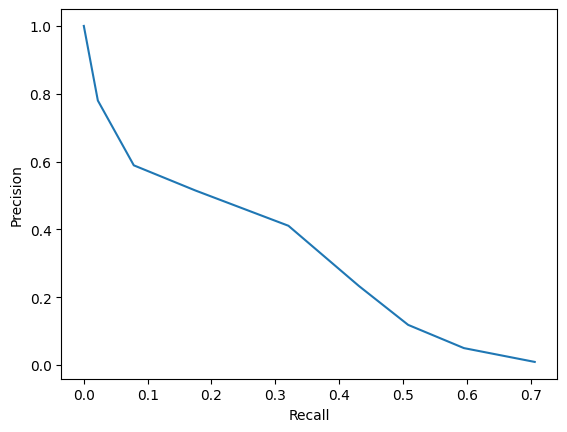

In [ ]:
val_precision_list1, val_recall_list1 = percision_recall_roc_curve(val_dataset, val_nms_preds_scores1)

#### Test

In [ ]:
test_preds_scores1 = retinaNet1._predict_scores(test_data_loader)
test_nms_preds_scores1 = retinaNet1._apply_non_maximum_surpression(test_preds_scores1)

100%|██████████| 355/355 [03:05<00:00,  1.91it/s]


In [ ]:
test_score1 = mAP(test_data_loader, test_nms_preds_scores1)
pprint(test_score1)

{'map': tensor(0.0416),
 'map_50': tensor(0.1542),
 'map_75': tensor(0.0048),
 'map_large': tensor(0.1428),
 'map_medium': tensor(0.0709),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0340),
 'mar_1': tensor(0.0429),
 'mar_10': tensor(0.1468),
 'mar_100': tensor(0.2180),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.4474),
 'mar_medium': tensor(0.3394),
 'mar_small': tensor(0.1733)}


<ipython-input-40-f86582829b14>:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  fp = len(np.where(np.array(all_pred_labels) == FP)[0])
<ipython-input-40-f86582829b14>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  tp = len(np.where(np.array(all_pred_labels) == TP)[0])


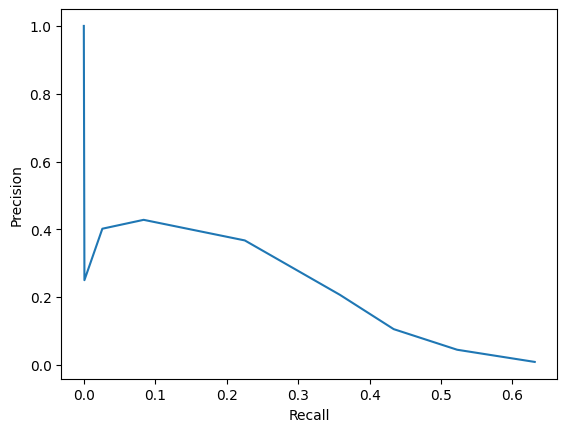

In [ ]:
test_precision_list1, test_recall_list1 = percision_recall_roc_curve(test_dataset, test_nms_preds_scores1)

# Retina 2 - fine tuning on UN-Normalized dataset

In [ ]:
retinaNet2 = RetinaNetModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
retinaNet2.load_trained_model('retina_old.pt')
# retina.train()

#### Validation

In [ ]:
val_preds_scores2 = retinaNet2._predict_scores(val_data_loader)
val_nms_preds_scores2 = retinaNet2._apply_non_maximum_surpression(val_preds_scores2)

100%|██████████| 284/284 [04:08<00:00,  1.14it/s]


In [ ]:
val_score2 = mAP(val_data_loader, val_nms_preds_scores2)
pprint(val_score2)

{'map': tensor(0.2266),
 'map_50': tensor(0.4745),
 'map_75': tensor(0.1904),
 'map_large': tensor(0.5479),
 'map_medium': tensor(0.3199),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1370),
 'mar_1': tensor(0.2211),
 'mar_10': tensor(0.2897),
 'mar_100': tensor(0.3026),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.5977),
 'mar_medium': tensor(0.4075),
 'mar_small': tensor(0.2355)}


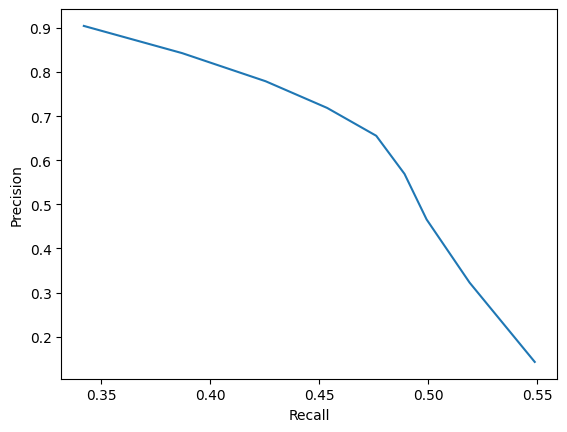

In [ ]:
val_precision_list2, val_recall_list2 = percision_recall_roc_curve(val_dataset, val_nms_preds_scores2)

#### Test

In [ ]:
test_preds_scores2 = retinaNet2._predict_scores(test_data_loader)
test_nms_preds_scores2 = retinaNet2._apply_non_maximum_surpression(test_preds_scores2)

100%|██████████| 355/355 [02:52<00:00,  2.06it/s]


In [ ]:
test_score2 = mAP(test_data_loader, test_nms_preds_scores2)
pprint(test_score2)

{'map': tensor(0.1962),
 'map_50': tensor(0.4463),
 'map_75': tensor(0.1485),
 'map_large': tensor(0.3800),
 'map_medium': tensor(0.3444),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1198),
 'mar_1': tensor(0.1199),
 'mar_10': tensor(0.2662),
 'mar_100': tensor(0.2870),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.4184),
 'mar_medium': tensor(0.5158),
 'mar_small': tensor(0.2070)}


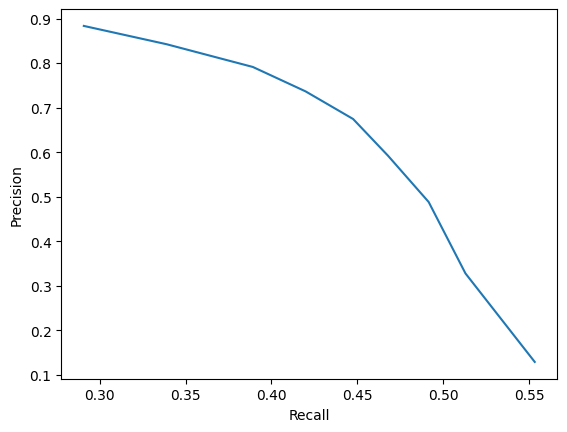

In [ ]:
test_precision_list2, test_recall_list2 = percision_recall_roc_curve(test_dataset, test_nms_preds_scores2)

# Retina 3 - Augmneted data

Filp, translate, rotate

In [ ]:
retinaNet3 = RetinaNetModel()

In [ ]:
retinaNet3.load_trained_model('retina.pt')

#### Validation

In [ ]:
val_preds_scores3 = retinaNet3._predict_scores(norm_val_data_loader)
val_nms_preds_scores3 = retinaNet3._apply_non_maximum_surpression(val_preds_scores3)

100%|██████████| 284/284 [01:24<00:00,  3.38it/s]


In [ ]:
val_score3 = mAP(norm_val_data_loader, val_nms_preds_scores3)
pprint(val_score3)

{'map': tensor(0.1920),
 'map_50': tensor(0.4217),
 'map_75': tensor(0.1348),
 'map_large': tensor(0.3628),
 'map_medium': tensor(0.2568),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1377),
 'mar_1': tensor(0.1985),
 'mar_10': tensor(0.2925),
 'mar_100': tensor(0.3265),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.4907),
 'mar_medium': tensor(0.4171),
 'mar_small': tensor(0.2718)}


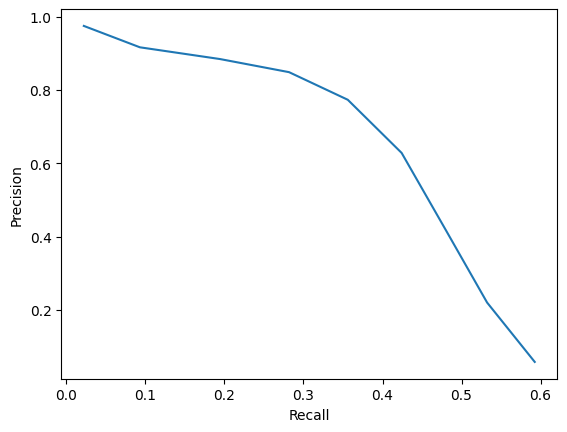

In [ ]:
val_precision_list3, val_recall_list3 = percision_recall_roc_curve(norm_val_dataset, val_nms_preds_scores3)

#### Test

In [ ]:
test_preds_scores3 = retinaNet3._predict_scores(norm_test_data_loader)
test_nms_preds_scores3 = retinaNet3._apply_non_maximum_surpression(test_preds_scores3)

100%|██████████| 355/355 [02:56<00:00,  2.01it/s]


In [ ]:
test_score3 = mAP(norm_test_data_loader, test_nms_preds_scores3)
pprint(test_score3)

{'map': tensor(0.1578),
 'map_50': tensor(0.3944),
 'map_75': tensor(0.0905),
 'map_large': tensor(0.6053),
 'map_medium': tensor(0.2739),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1042),
 'mar_1': tensor(0.0951),
 'mar_10': tensor(0.2596),
 'mar_100': tensor(0.3036),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6579),
 'mar_medium': tensor(0.5004),
 'mar_small': tensor(0.2312)}


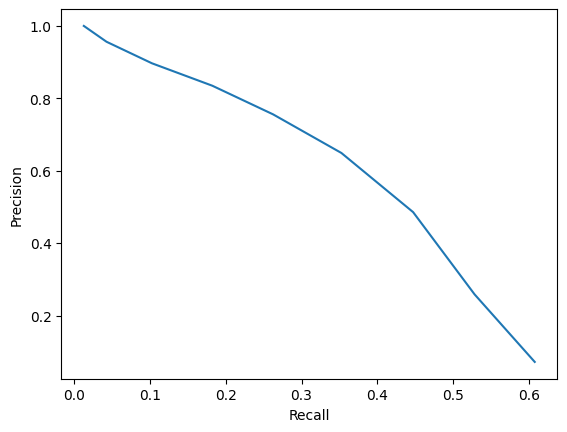

In [ ]:
test_precision_list3, test_recall_list3 = percision_recall_roc_curve(norm_test_dataset, test_nms_preds_scores3)

# Fined-tune Model - Selected Model
####  Normalized data

In [ ]:
retinaNet_best = RetinaNetModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
retinaNet_best.load_trained_model('retina_bs2_e5.pt')

#### Validation

In [ ]:
val_preds_scores_best = retinaNet_best._predict_scores(norm_val_data_loader)
val_nms_preds_scores_best = retinaNet_best._apply_non_maximum_surpression(val_preds_scores_best)

100%|██████████| 284/284 [01:24<00:00,  3.35it/s]


In [ ]:
val_score_best = mAP(norm_val_data_loader, val_nms_preds_scores_best)
pprint(val_score_best)

{'map': tensor(0.2240),
 'map_50': tensor(0.4926),
 'map_75': tensor(0.1678),
 'map_large': tensor(0.2967),
 'map_medium': tensor(0.3260),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1504),
 'mar_1': tensor(0.2159),
 'mar_10': tensor(0.2985),
 'mar_100': tensor(0.3254),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.3512),
 'mar_medium': tensor(0.4146),
 'mar_small': tensor(0.2769)}


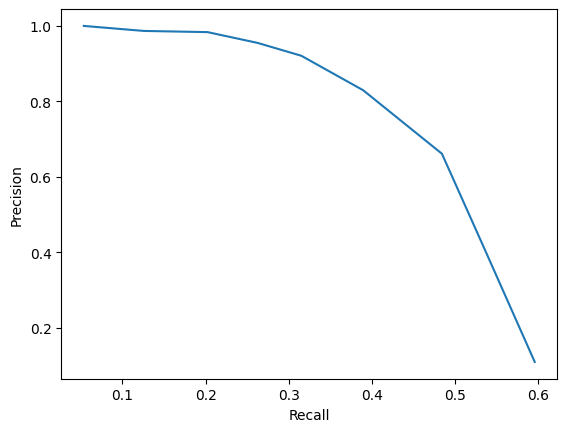

In [ ]:
val_precision_list_best, val_recall_list_best = percision_recall_roc_curve(norm_val_dataset, val_nms_preds_scores_best)

#### Test

In [ ]:
test_preds_scores_best = retinaNet_best._predict_scores(norm_test_data_loader)
test_nms_preds_scores_best = retinaNet_best._apply_non_maximum_surpression(test_preds_scores_best)

100%|██████████| 355/355 [01:42<00:00,  3.48it/s]


In [ ]:
test_score_best = mAP(norm_test_data_loader, test_nms_preds_scores_best)
pprint(test_score_best)

{'map': tensor(0.1813),
 'map_50': tensor(0.4555),
 'map_75': tensor(0.1097),
 'map_large': tensor(0.4591),
 'map_medium': tensor(0.3212),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1225),
 'mar_1': tensor(0.1043),
 'mar_10': tensor(0.2681),
 'mar_100': tensor(0.3078),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.5079),
 'mar_medium': tensor(0.5136),
 'mar_small': tensor(0.2347)}


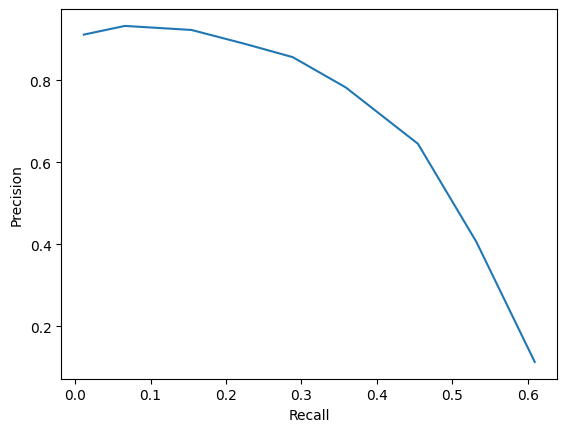

In [ ]:
test_precision_list_best, test_recall_list_best = percision_recall_roc_curve(norm_test_dataset, test_nms_preds_scores_best)

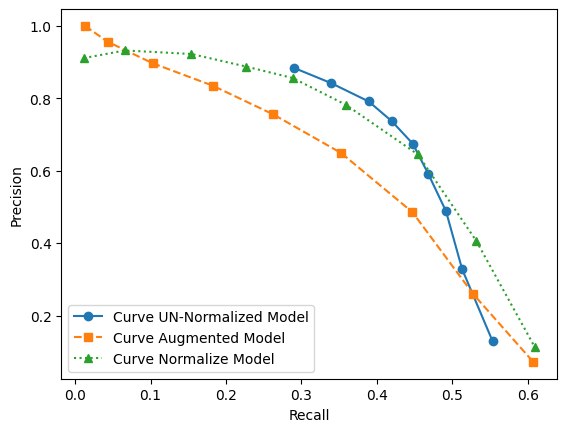

In [ ]:
plt.plot(test_recall_list2, test_precision_list2, label='Curve UN-Normalized Model', linestyle='-', marker='o')
plt.plot(test_recall_list3, test_precision_list3, label='Curve Augmented Model', linestyle='--', marker='s')
plt.plot(test_recall_list_best, test_precision_list_best, label='Curve Normalize Model', linestyle=':', marker='^')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()